# Feature Columns in Tensorflow 2.0

Inspired by https://www.tensorflow.org/alpha/tutorials/keras/feature_columns

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/australian_credit.csv')

- Data adapted from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data)
- Attributes from [here](https://www.researchgate.net/publication/3297254_A_Compact_and_Accurate_Model_for_Classification)


|Column| Values| Type|
| :--- | :---  | :--- |
|A1 (Sex) |  0, 1 |Nominal|
|A2 (Age) |  13.75 - 80.25 |Continuous|
|A3 (Mean time at addresses) |  0 - 28 |Continuous|
|A4 (Home status) |  1, 2, 3 |Nominal|
|A5 (Current occupation) |  1 - 14 |Nominal|
|A6 (Current job status) |  1 - 9 |Nominal|
|A7 (Mean time with employers) |  0 - 28.5 |Continuous|
|A8 (Other investments) |  0, 1 |Nominal|
|A9 (Bank account) |  0, 1 |Nominal|
|A10 (Time with bank) |  0 - 67 |Continuous|
|A11 (Liability reference) |  0, 1 |Nominal|
|A12 (Account reference) |  1, 2, 3 |Nominal|
|A13 (Monthly housing expense) |  0 - 2000 |Continuous|
|A14 (Savings account balance) |  1 - 100001 |Continuous| 

In [3]:
df.head()

,sex,age,time_at_addr,home_status,occupation,job_status,time_w_empl,investments,bank_account,time_w_bank,liability_ref,account_ref,monthly_housing,savings_balance,class
0,b,30.83,0.000,u,w,v,1.25,t,t,1,f,g,202.0,0,1
1,a,58.67,4.460,u,q,h,3.04,t,t,6,f,g,43.0,560,1
2,a,24.50,0.500,u,q,h,1.50,t,f,0,f,g,280.0,824,1
3,b,27.83,1.540,u,w,v,3.75,t,t,5,t,g,100.0,3,1
4,b,20.17,5.625,u,w,v,1.71,t,f,0,f,s,120.0,0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 15 columns):
sex                653 non-null object
age                653 non-null float64
time_at_addr       653 non-null float64
home_status        653 non-null object
occupation         653 non-null object
job_status         653 non-null object
time_w_empl        653 non-null float64
investments        653 non-null object
bank_account       653 non-null object
time_w_bank        653 non-null int64
liability_ref      653 non-null object
account_ref        653 non-null object
monthly_housing    653 non-null float64
savings_balance    653 non-null int64
class              653 non-null int64
dtypes: float64(4), int64(3), object(8)
memory usage: 76.6+ KB


In [5]:
df.describe()

,age,time_at_addr,time_w_empl,time_w_bank,monthly_housing,savings_balance,class
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,31.503813,4.829533,2.244296,2.502297,180.359877,1013.761103,0.453292
std,11.838267,5.027077,3.371120,4.968497,168.296811,5253.278504,0.498195
min,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.580000,1.040000,0.165000,0.000000,73.000000,0.000000,0.000000
50%,28.420000,2.835000,1.000000,0.000000,160.000000,5.000000,0.000000
75%,38.250000,7.500000,2.625000,3.000000,272.000000,400.000000,1.000000
max,76.750000,28.000000,28.500000,67.000000,2000.000000,100000.000000,1.000000


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
train_val, test = train_test_split(df, test_size=0.2, random_state=0)
train, val = train_test_split(train_val, test_size=0.2, random_state=0)

In [8]:
train.shape

(417, 15)

In [9]:
val.shape

(105, 15)

In [10]:
test.shape

(131, 15)

## Batch generation with tf.data.Dataset

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('class')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [12]:
batch_size = 5

In [13]:
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [14]:
for feature_batch, label_batch in train_ds.take(1):
    print('Every feature:', list(feature_batch.keys()))
    print('A batch of ages:', feature_batch['age'])
    print('A batch of targets:', label_batch )

Every feature: ['sex', 'age', 'time_at_addr', 'home_status', 'occupation', 'job_status', 'time_w_empl', 'investments', 'bank_account', 'time_w_bank', 'liability_ref', 'account_ref', 'monthly_housing', 'savings_balance']
A batch of ages: tf.Tensor([32.75 28.25 27.83 28.58 22.92], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([1 1 0 0 0], shape=(5,), dtype=int32)


In [15]:
example_batch = next(iter(train_ds))[0]

## Feature Columns

In [16]:
def demo(feature_column):
    feature_layer = tf.keras.layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch).numpy())

In [17]:
age = tf.feature_column.numeric_column("age")
demo(age)

W0329 06:11:42.114364 139783543281408 deprecation.py:323] From /home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


[[32.75]
 [28.25]
 [27.83]
 [28.58]
 [22.92]]


In [18]:
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

W0329 06:11:42.127237 139783543281408 deprecation.py:323] From /home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2902: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
occupation_vocab = df['occupation'].unique()
occupation_vocab

array(['w', 'q', 'm', 'r', 'cc', 'k', 'c', 'd', 'x', 'i', 'e', 'aa', 'ff',
       'j'], dtype=object)

In [20]:
occupation = tf.feature_column.categorical_column_with_vocabulary_list(
      'occupation', occupation_vocab)
occupation_one_hot = tf.feature_column.indicator_column(occupation)
demo(occupation_one_hot)

W0329 06:11:42.396471 139783543281408 deprecation.py:323] From /home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0329 06:11:42.397321 139783543281408 deprecation.py:323] From /home/ubuntu/miniconda3/lib/python3.7/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4362: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [21]:
occupation_embedding = tf.feature_column.embedding_column(occupation, dimension=8)
demo(occupation_embedding)

[[ 0.00183103 -0.6234342  -0.03435355  0.2713414  -0.18070084  0.04156457
   0.15374899  0.3670841 ]
 [ 0.37766615 -0.53194654 -0.40429667 -0.3435668  -0.46379837 -0.20837507
  -0.17402548 -0.39803824]
 [ 0.38586622 -0.08016809 -0.21165289 -0.5197539   0.1008313   0.20515911
   0.02135343 -0.0274979 ]
 [ 0.38586622 -0.08016809 -0.21165289 -0.5197539   0.1008313   0.20515911
   0.02135343 -0.0274979 ]
 [ 0.07441183  0.38172042  0.48825887  0.18285328 -0.09967142  0.5593369
  -0.5063273   0.39926842]]


In [33]:
occupation_hashed = tf.feature_column.categorical_column_with_hash_bucket(
      'occupation', hash_bucket_size=1000)
occupation_hashed = tf.feature_column.indicator_column(occupation_hashed)
demo(occupation_hashed)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
crossed_feature = tf.feature_column.crossed_column([age_buckets, occupation], hash_bucket_size=1000)
crossed_feature = tf.feature_column.indicator_column(crossed_feature)
demo(crossed_feature)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [36]:
numeric_cols = ['age', 'time_at_addr', 'time_w_empl', 'time_w_bank', 'monthly_housing', 'savings_balance']

In [38]:
feature_columns = []

for c in numeric_cols:
    feature_columns.append(tf.feature_column.numeric_column(c))
    
feature_columns.append(age_buckets)
feature_columns.append(occupation_one_hot)
feature_columns.append(occupation_embedding)
feature_columns.append(crossed_feature)

## Model Train and Evaluate

### Baseline

In [87]:
classes_ratio = df['class'].value_counts() / len(df)
classes_ratio

0    0.546708
1    0.453292
Name: class, dtype: float64

In [88]:
baseline = classes_ratio[0]
baseline

0.5467075038284839

### Model

In [67]:
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop

In [81]:
model = Sequential([
  DenseFeatures(feature_columns),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [82]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [83]:
h = model.fit(train_ds, 
              validation_data=val_ds, 
              epochs=15)

Epoch 1/15
14/14 [==============================] - 1s 65ms/step - loss: 2.3813 - accuracy: 0.6562 - val_loss: 2.0448 - val_accuracy: 0.6286
Epoch 2/15
14/14 [==============================] - 1s 48ms/step - loss: 1.5745 - accuracy: 0.6642 - val_loss: 1.1441 - val_accuracy: 0.6286
Epoch 3/15
14/14 [==============================] - 1s 47ms/step - loss: 0.7429 - accuracy: 0.6621 - val_loss: 0.7922 - val_accuracy: 0.6000
Epoch 4/15
14/14 [==============================] - 1s 48ms/step - loss: 0.6846 - accuracy: 0.6906 - val_loss: 0.8049 - val_accuracy: 0.5429
Epoch 5/15
14/14 [==============================] - 1s 49ms/step - loss: 0.6564 - accuracy: 0.6846 - val_loss: 0.7727 - val_accuracy: 0.6286
Epoch 6/15
14/14 [==============================] - 1s 48ms/step - loss: 0.6208 - accuracy: 0.6942 - val_loss: 0.7377 - val_accuracy: 0.6000
Epoch 7/15
14/14 [==============================] - 1s 48ms/step - loss: 0.6141 - accuracy: 0.7078 - val_loss: 0.7347 - val_accuracy: 0.6000
Epoch 8/15
14

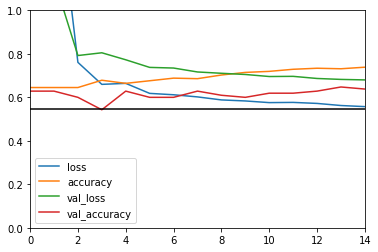

In [90]:
pd.DataFrame(h.history).plot()
plt.ylim(0, 1)
plt.axhline(baseline, c='black');

In [85]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

5/5 [==============================] - 0s 24ms/step - loss: 0.5743 - accuracy: 0.7328
Accuracy 0.73282444


## Exercise 

Add other feature columns and iterate to improve the model